# Read in dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import sys
from sklearn.model_selection import train_test_split
import os
import json
import gzip
from urllib.request import urlopen

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')


from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding

df_reviews = pd.read_json('Magazine_Subscriptions.json', lines=True)
df_reviews.head()




2023-07-03 14:59:26.916048: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stevenschindler/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/stevenschindler/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/stevenschindler/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/stevenschindler/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
0,5,9,False,"11 8, 2001",AH2IFH762VY5U,B00005N7P0,ted sedlmayr,"for computer enthusiast, MaxPC is a welcome si...","AVID READER SINCE ""boot"" WAS THE NAME",1005177600,NaN,NaN
1,5,9,False,"10 31, 2001",AOSFI0JEYU4XM,B00005N7P0,Amazon Customer,Thank god this is not a Ziff Davis publication...,The straight scoop,1004486400,NaN,NaN
2,3,14,False,"03 24, 2007",A3JPFWKS83R49V,B00005N7OJ,Bryan Carey,Antiques Magazine is a publication made for an...,"Antiques Magazine is Good, but not for Everyone",1174694400,{'Format:': ' Print Magazine'},NaN
3,5,13,False,"11 10, 2006",A19FKU6JZQ2ECJ,B00005N7OJ,Patricia L. Porada,This beautiful magazine is in itself a work of...,THE DISCERNING READER,1163116800,{'Format:': ' Print Magazine'},NaN
4,5,NaN,True,"07 14, 2014",A25MDGOMZ2GALN,B00005N7P0,Alvey,A great read every issue.,Five Stars,1405296000,NaN,NaN


# Data exploration

In [2]:


df_reviews.shape

(89689, 12)

In [3]:
df_reviews.head()

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
0,5,9,False,"11 8, 2001",AH2IFH762VY5U,B00005N7P0,ted sedlmayr,"for computer enthusiast, MaxPC is a welcome si...","AVID READER SINCE ""boot"" WAS THE NAME",1005177600,NaN,NaN
1,5,9,False,"10 31, 2001",AOSFI0JEYU4XM,B00005N7P0,Amazon Customer,Thank god this is not a Ziff Davis publication...,The straight scoop,1004486400,NaN,NaN
2,3,14,False,"03 24, 2007",A3JPFWKS83R49V,B00005N7OJ,Bryan Carey,Antiques Magazine is a publication made for an...,"Antiques Magazine is Good, but not for Everyone",1174694400,{'Format:': ' Print Magazine'},NaN
3,5,13,False,"11 10, 2006",A19FKU6JZQ2ECJ,B00005N7OJ,Patricia L. Porada,This beautiful magazine is in itself a work of...,THE DISCERNING READER,1163116800,{'Format:': ' Print Magazine'},NaN
4,5,NaN,True,"07 14, 2014",A25MDGOMZ2GALN,B00005N7P0,Alvey,A great read every issue.,Five Stars,1405296000,NaN,NaN


In [4]:
df_reviews.shape

(89689, 12)

<AxesSubplot:xlabel='overall', ylabel='count'>

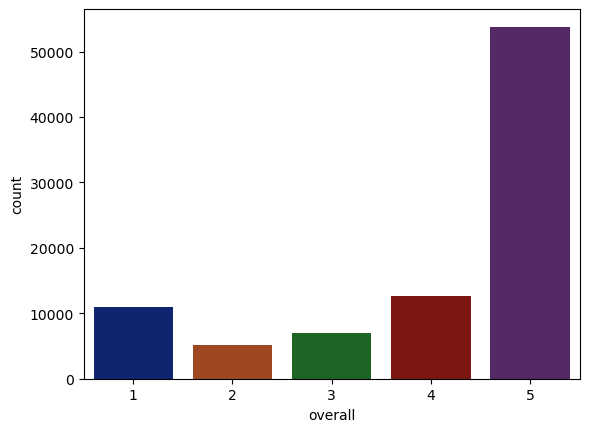

In [5]:

sns.countplot(data=df_reviews,x='overall',palette="dark")

In [6]:
df_reviews['overall'] = df_reviews['overall'].astype(int)
df = df_reviews[['overall','reviewText']]
df = df.dropna(axis=0)
df.head()

,overall,reviewText
0,5,"for computer enthusiast, MaxPC is a welcome si..."
1,5,Thank god this is not a Ziff Davis publication...
2,3,Antiques Magazine is a publication made for an...
3,5,This beautiful magazine is in itself a work of...
4,5,A great read every issue.


In [7]:
df.reviewText

0        for computer enthusiast, MaxPC is a welcome si...
1        Thank god this is not a Ziff Davis publication...
2        Antiques Magazine is a publication made for an...
3        This beautiful magazine is in itself a work of...
4                                A great read every issue.
                               ...                        
89684    This was a nice surprise for my boyfriend. He ...
89685    Magazine looks like it is printed on recycled ...
89686    cant go wrong with an SI subscription\nvery pl...
89687    This magazine is by far my all time favorite o...
89688               Nice magazine. Good info and articles.
Name: reviewText, Length: 89656, dtype: object

In [8]:
df = df.rename(columns={'reviewText': 'review_text'})

# Data Preparation and Cleaning

In [9]:
text = df.review_text

list_of_char = []
for t in text:
    for char in t:
        if char not in list_of_char:
            list_of_char.append(char)
print(list_of_char)

['f', 'o', 'r', ' ', 'c', 'm', 'p', 'u', 't', 'e', 'n', 'h', 's', 'i', 'a', ',', 'M', 'x', 'P', 'C', 'w', 'l', 'g', 'y', 'b', '.', 'v', '"', '(', 'd', ')', "'", 'A', '-', 'k', 'D', 'R', 'O', 'U', 'I', 'T', '1', '0', 'V', 'q', 'Z', 'j', ';', 'z', '\n', 'E', 'S', 'B', 'L', 'F', '8', '7', 'Y', '!', 'W', '3', '/', 'H', 'N', '$', '5', ':', 'G', '?', '[', ']', '2', '9', '4', 'Q', '6', 'J', '*', '&', '+', 'K', '_', '@', '%', 'X', '#', '`', '^', '=', '\\', '>', '~', '<', '\x1b', '{', '}', '|']


In [10]:

stop = stopwords.words('english')

df['review_text'].apply(lambda x: [item for item in x if item not in stop])


0        [f, r,  , c, p, u, e, r,  , e, n, h, u, ,,  , ...
1        [T, h, n, k,  , g,  , h,  ,  , n,  ,  , Z, f, ...
2        [A, n, q, u, e,  , M, g, z, n, e,  ,  ,  , p, ...
3        [T, h,  , b, e, u, f, u, l,  , g, z, n, e,  , ...
4        [A,  , g, r, e,  , r, e,  , e, v, e, r,  , u, ...
                               ...                        
89684    [T, h,  , w,  ,  , n, c, e,  , u, r, p, r, e, ...
89685    [M, g, z, n, e,  , l, k,  , l, k, e,  ,  ,  , ...
89686    [c, n,  , g,  , w, r, n, g,  , w, h,  , n,  , ...
89687    [T, h,  , g, z, n, e,  ,  , b,  , f, r,  ,  , ...
89688    [N, c, e,  , g, z, n, e, .,  , G,  , n, f,  , ...
Name: review_text, Length: 89656, dtype: object

In [11]:
description_list = []
for description in df.review_text:

    description = re.sub("[^a-zA-Z]", " ", description) 
    
#Convert to lower case
    description = description.lower()
    
#Perform tokenization
    description=nltk.word_tokenize(description)

    description = " ".join(description)
    
    description_list.append(description)

 



In [12]:
 #Perform lemmatization
lemma = nltk.WordNetLemmatizer()
description = [lemma.lemmatize(word) for word in description_list]

In [13]:
#print(description_list)

In [14]:


tokenizer = Tokenizer()
tokenizer.fit_on_texts(description_list)
vocab_size=len(tokenizer.word_index)+1
print("Vocab size:",vocab_size)

Vocab size: 46327


In [15]:


max_sequence_embedding = int(round(np.sqrt(np.sqrt(vocab_size)), 0))
max_sequence_embedding

15

In [16]:
seq_length = []
text = description_list
for t in text:
    seq_length.append(len(t.split(' ')))


seq_max = int(round(np.max(seq_length),0))
print("max length is: ",seq_max)
print("index of max length is: ",np.argmax(seq_length))

max length is:  5026
index of max length is:  86067


In [17]:
#text[86067]#nonsensical ranting

In [18]:
x = np.array(description_list)
y = df.overall.values


x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=.20, random_state = 18)

y_train = pd.Series(y_train)
y_test = pd.Series(y_test)




In [19]:
x_test.shape

(17932,)

In [20]:
tokenizer = Tokenizer(num_words=vocab_size,oov_token='<OOV>')
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index
print(word_index)

In [21]:

sequences = tokenizer.texts_to_sequences(x_train)

padded_train = pad_sequences(sequences,maxlen=seq_max,padding='post',truncating='post')

sequences_test = tokenizer.texts_to_sequences(x_test)

padded_test = pad_sequences(sequences_test,maxlen=seq_max,padding='post',truncating='post')

np.set_printoptions(threshold=sys.maxsize)
padded_train[10]

array([  15,  321,  155,   12,    9,    3,  104,    2,   29,   91,  300,
       2680,   24,  158,  192, 1337, 1789,   48,    2,  356,  176,   40,
          2, 3859,  154,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [22]:
print(padded_test.shape)
print(padded_train.shape)

print(y_train.shape)
print(y_test.shape)

(17932, 5026)
(71724, 5026)
(71724,)
(17932,)


In [23]:
pd.DataFrame(padded_train).to_csv('padded_x_train.csv')
pd.DataFrame(padded_test).to_csv('padded_x_test.csv')
pd.DataFrame(y_train).to_csv('y_train.csv')
pd.DataFrame(y_test).to_csv('y_test.csv')

# NLP and Sentiment analysis

In [24]:

activation ='softmax'
loss = 'sparse_categorical_crossentropy'
optimizer ='adam'
num_epochs = 25
embedding_dim = 16

early_stopping_monitor = EarlyStopping(patience=3)

model = tf.keras.Sequential([
    
tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=seq_max),
tf.keras.layers.GlobalAveragePooling1D(),
tf.keras.layers.Flatten(),

tf.keras.layers.Dense(100,activation='relu'),
tf.keras.layers.Dropout(0.5), #dropout with 50% rate
tf.keras.layers.Dense(50,activation='relu'),
tf.keras.layers.Dense(6,activation=activation)



])
model.compile(loss=loss,optimizer=optimizer,metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5026, 16)          741232    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 flatten (Flatten)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 100)               1700      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                        

In [26]:
history = model.fit(padded_train, y_train, batch_size=64 ,epochs=num_epochs,validation_data =(padded_test,y_test),callbacks=[early_stopping_monitor])


Epoch 1/25
1121/1121 [==============================] - 23s 20ms/step - loss: 1.2301 - accuracy: 0.5989 - val_loss: 1.1950 - val_accuracy: 0.6025
Epoch 2/25
1121/1121 [==============================] - 22s 20ms/step - loss: 1.1755 - accuracy: 0.5984 - val_loss: 1.1289 - val_accuracy: 0.6050
Epoch 3/25
1121/1121 [==============================] - 22s 19ms/step - loss: 1.0438 - accuracy: 0.6214 - val_loss: 0.9468 - val_accuracy: 0.6554
Epoch 4/25
1121/1121 [==============================] - 21s 19ms/step - loss: 0.9438 - accuracy: 0.6536 - val_loss: 0.9714 - val_accuracy: 0.6553
Epoch 5/25
1121/1121 [==============================] - 22s 20ms/step - loss: 0.9165 - accuracy: 0.6631 - val_loss: 0.9421 - val_accuracy: 0.6643
Epoch 6/25
1121/1121 [==============================] - 21s 19ms/step - loss: 0.9021 - accuracy: 0.6675 - val_loss: 0.8983 - val_accuracy: 0.6727
Epoch 7/25
1121/1121 [==============================] - 21s 19ms/step - loss: 0.8899 - accuracy: 0.6718 - val_loss: 0.8833 -

In [27]:
score = model.evaluate(padded_test,y_test,verbose = 0)

In [28]:
print(f'Test loss: {score[0]}, Test Accuracy: {score[1]}')

Test loss: 0.8073317408561707, Test Accuracy: 0.7016506791114807


In [29]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Get training and test accuracy histories
training_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

In [30]:
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visulization

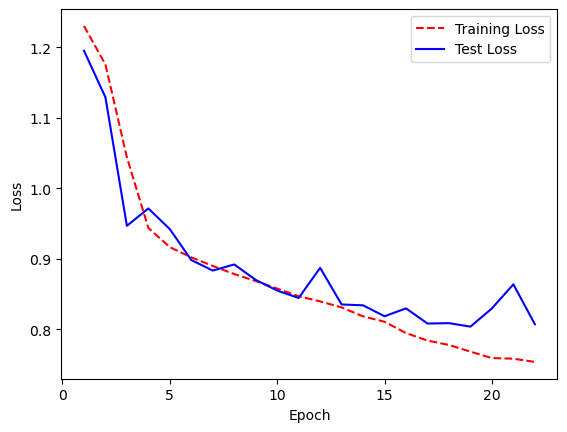

In [31]:
import matplotlib.pyplot as plt
# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

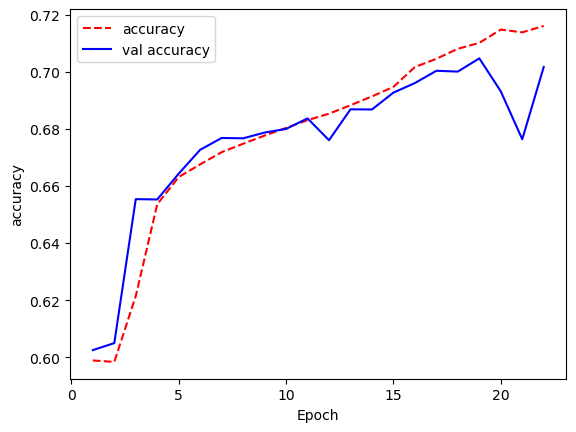

In [32]:
# Visualize loss history
plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, test_accuracy, 'b-')
plt.legend(['accuracy', 'val accuracy'])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.show();

In [33]:
predictions = model.predict(padded_test)
i = 200
print("predictted review text:", x_test[i],"\n")
print("Predicted: ", "Negative" if predictions[i][0] >= 0.5 else "Positive","review")
print("Actual: ", "Positive" if y_test[i] == 5 or y_test[i] == 4 else "Negative","review")

561/561 [==============================] - 2s 4ms/step
predictted review text: i have enjoyed this publication for many years it is great to receive the magazine on both my kindle fire hd and a print copy thank you for offering this terrific deal 

Predicted:  Positive review
Actual:  Positive review


In [34]:
model.save("sentimnent_analysis.h5")